Disclaimer: Nothing herein is financial advice, and NOT a recommendation to trade real money. Many platforms exist for simulated trading (paper trading) which can be used for building and developing the methods discussed. Please use common sense and always first consult a professional before trading or investing.

## Import related modules

# **Agent PPO**

In [1]:
import os
import time
import gym
import numpy as np
import numpy.random as rd
import torch
import torch.nn as nn
from copy import deepcopy
from torch import Tensor
from torch.distributions.normal import Normal


class ActorPPO(nn.Module):
    def __init__(self, dims: [int], state_dim: int, action_dim: int):
        super().__init__()
        self.net = build_mlp(dims=[state_dim, *dims, action_dim])
        self.action_std_log = nn.Parameter(torch.zeros((1, action_dim)), requires_grad=True)  # trainable parameter

    def forward(self, state: Tensor) -> Tensor:
        return self.net(state).tanh()  # action.tanh()

    def get_action(self, state: Tensor) -> (Tensor, Tensor):  # for exploration
        action_avg = self.net(state)
        action_std = self.action_std_log.exp()

        dist = Normal(action_avg, action_std)
        action = dist.sample()
        logprob = dist.log_prob(action).sum(1)
        return action, logprob

    def get_logprob_entropy(self, state: Tensor, action: Tensor) -> (Tensor, Tensor):
        action_avg = self.net(state)
        action_std = self.action_std_log.exp()

        dist = Normal(action_avg, action_std)
        logprob = dist.log_prob(action).sum(1)
        entropy = dist.entropy().sum(1)
        return logprob, entropy

    @staticmethod
    def convert_action_for_env(action: Tensor) -> Tensor:
        return action.tanh()


class CriticPPO(nn.Module):
    def __init__(self, dims: [int], state_dim: int, _action_dim: int):
        super().__init__()
        self.net = build_mlp(dims=[state_dim, *dims, 1])

    def forward(self, state: Tensor) -> Tensor:
        return self.net(state)  # advantage value


def build_mlp(dims: [int]) -> nn.Sequential:  # MLP (MultiLayer Perceptron)
    net_list = []
    for i in range(len(dims) - 1):
        net_list.extend([nn.Linear(dims[i], dims[i + 1]), nn.ReLU()])
    del net_list[-1]  # remove the activation of output layer
    return nn.Sequential(*net_list)


class Config:
    def __init__(self, agent_class=None, env_class=None, env_args=None):
        self.env_class = env_class  # env = env_class(**env_args)
        self.env_args = env_args  # env = env_class(**env_args)

        if env_args is None:  # dummy env_args
            env_args = {'env_name': None, 'state_dim': None, 'action_dim': None, 'if_discrete': None}
        self.env_name = env_args['env_name']  # the name of environment. Be used to set 'cwd'.
        self.state_dim = env_args['state_dim']  # vector dimension (feature number) of state
        self.action_dim = env_args['action_dim']  # vector dimension (feature number) of action
        self.if_discrete = env_args['if_discrete']  # discrete or continuous action space

        self.agent_class = agent_class  # agent = agent_class(...)

        '''Arguments for reward shaping'''
        self.gamma = 0.99  # discount factor of future rewards
        self.reward_scale = 1.0  # an approximate target reward usually be closed to 256

        '''Arguments for training'''
        self.gpu_id = int(0)  # `int` means the ID of single GPU, -1 means CPU
        self.net_dims = (64, 32)  # the middle layer dimension of MLP (MultiLayer Perceptron)
        self.learning_rate = 6e-5  # 2 ** -14 ~= 6e-5
        self.soft_update_tau = 5e-3  # 2 ** -8 ~= 5e-3
        self.batch_size = int(128)  # num of transitions sampled from replay buffer.
        self.horizon_len = int(2000)  # collect horizon_len step while exploring, then update network
        self.buffer_size = None  # ReplayBuffer size. Empty the ReplayBuffer for on-policy.
        self.repeat_times = 8.0  # repeatedly update network using ReplayBuffer to keep critic's loss small

        '''Arguments for evaluate'''
        self.cwd = None  # current working directory to save model. None means set automatically
        self.break_step = +np.inf  # break training if 'total_step > break_step'
        self.eval_times = int(32)  # number of times that get episodic cumulative return
        self.eval_per_step = int(2e4)  # evaluate the agent per training steps

    def init_before_training(self):
        if self.cwd is None:  # set cwd (current working directory) for saving model
            self.cwd = f'./{self.env_name}_{self.agent_class.__name__[5:]}'
        os.makedirs(self.cwd, exist_ok=True)


def get_gym_env_args(env, if_print: bool) -> dict:
    if {'unwrapped', 'observation_space', 'action_space', 'spec'}.issubset(dir(env)):  # isinstance(env, gym.Env):
        env_name = env.unwrapped.spec.id
        state_shape = env.observation_space.shape
        state_dim = state_shape[0] if len(state_shape) == 1 else state_shape  # sometimes state_dim is a list

        if_discrete = isinstance(env.action_space, gym.spaces.Discrete)
        if if_discrete:  # make sure it is discrete action space
            action_dim = env.action_space.n
        elif isinstance(env.action_space, gym.spaces.Box):  # make sure it is continuous action space
            action_dim = env.action_space.shape[0]

    env_args = {'env_name': env_name, 'state_dim': state_dim, 'action_dim': action_dim, 'if_discrete': if_discrete}
    print(f"env_args = {repr(env_args)}") if if_print else None
    return env_args


def kwargs_filter(function, kwargs: dict) -> dict:
    import inspect
    sign = inspect.signature(function).parameters.values()
    sign = {val.name for val in sign}
    common_args = sign.intersection(kwargs.keys())
    return {key: kwargs[key] for key in common_args}  # filtered kwargs


def build_env(env_class=None, env_args=None):
    if env_class.__module__ == 'gym.envs.registration':  # special rule
        env = env_class(id=env_args['env_name'])
    else:
        env = env_class(**kwargs_filter(env_class.__init__, env_args.copy()))
    for attr_str in ('env_name', 'state_dim', 'action_dim', 'if_discrete'):
        setattr(env, attr_str, env_args[attr_str])
    return env


class AgentBase:
    def __init__(self, net_dims: [int], state_dim: int, action_dim: int, gpu_id: int = 0, args: Config = Config()):
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.gamma = args.gamma
        self.batch_size = args.batch_size
        self.repeat_times = args.repeat_times
        self.reward_scale = args.reward_scale
        self.soft_update_tau = args.soft_update_tau

        self.states = None  # assert self.states == (1, state_dim)
        self.device = torch.device(f"cuda:{gpu_id}" if (torch.cuda.is_available() and (gpu_id >= 0)) else "cpu")

        act_class = getattr(self, "act_class", None)
        cri_class = getattr(self, "cri_class", None)
        self.act = self.act_target = act_class(net_dims, state_dim, action_dim).to(self.device)
        self.cri = self.cri_target = cri_class(net_dims, state_dim, action_dim).to(self.device) \
            if cri_class else self.act

        self.act_optimizer = torch.optim.Adam(self.act.parameters(), args.learning_rate)
        self.cri_optimizer = torch.optim.Adam(self.cri.parameters(), args.learning_rate) \
            if cri_class else self.act_optimizer

        self.criterion = torch.nn.SmoothL1Loss()

    @staticmethod
    def optimizer_update(optimizer, objective: Tensor):
        optimizer.zero_grad()
        objective.backward()
        optimizer.step()

    @staticmethod
    def soft_update(target_net: torch.nn.Module, current_net: torch.nn.Module, tau: float):
        for tar, cur in zip(target_net.parameters(), current_net.parameters()):
            tar.data.copy_(cur.data * tau + tar.data * (1.0 - tau))


class AgentPPO(AgentBase):
    def __init__(self, net_dims: [int], state_dim: int, action_dim: int, gpu_id: int = 0, args: Config = Config()):
        self.if_off_policy = False
        self.act_class = getattr(self, "act_class", ActorPPO)
        self.cri_class = getattr(self, "cri_class", CriticPPO)
        AgentBase.__init__(self, net_dims, state_dim, action_dim, gpu_id, args)

        self.ratio_clip = getattr(args, "ratio_clip", 0.25)  # `ratio.clamp(1 - clip, 1 + clip)`
        self.lambda_gae_adv = getattr(args, "lambda_gae_adv", 0.95)  # could be 0.80~0.99
        self.lambda_entropy = getattr(args, "lambda_entropy", 0.01)  # could be 0.00~0.10
        self.lambda_entropy = torch.tensor(self.lambda_entropy, dtype=torch.float32, device=self.device)

    def explore_env(self, env, horizon_len: int) -> [Tensor]:
        states = torch.zeros((horizon_len, self.state_dim), dtype=torch.float32).to(self.device)
        actions = torch.zeros((horizon_len, self.action_dim), dtype=torch.float32).to(self.device)
        logprobs = torch.zeros(horizon_len, dtype=torch.float32).to(self.device)
        rewards = torch.zeros(horizon_len, dtype=torch.float32).to(self.device)
        dones = torch.zeros(horizon_len, dtype=torch.bool).to(self.device)

        ary_state = self.states[0]

        get_action = self.act.get_action
        convert = self.act.convert_action_for_env
        for i in range(horizon_len):
            state = torch.as_tensor(ary_state, dtype=torch.float32, device=self.device)
            action, logprob = [t.squeeze(0) for t in get_action(state.unsqueeze(0))[:2]]

            ary_action = convert(action).detach().cpu().numpy()
            ary_state, reward, done, _ = env.step(ary_action)
            if done:
                ary_state = env.reset()

            states[i] = state
            actions[i] = action
            logprobs[i] = logprob
            rewards[i] = reward
            dones[i] = done

        self.states[0] = ary_state
        rewards = (rewards * self.reward_scale).unsqueeze(1)
        undones = (1 - dones.type(torch.float32)).unsqueeze(1)
        return states, actions, logprobs, rewards, undones

    def update_net(self, buffer) -> [float]:
        with torch.no_grad():
            states, actions, logprobs, rewards, undones = buffer
            buffer_size = states.shape[0]

            '''get advantages reward_sums'''
            bs = 2 ** 10  # set a smaller 'batch_size' when out of GPU memory.
            values = [self.cri(states[i:i + bs]) for i in range(0, buffer_size, bs)]
            values = torch.cat(values, dim=0).squeeze(1)  # values.shape == (buffer_size, )

            advantages = self.get_advantages(rewards, undones, values)  # advantages.shape == (buffer_size, )
            reward_sums = advantages + values  # reward_sums.shape == (buffer_size, )
            del rewards, undones, values

            advantages = (advantages - advantages.mean()) / (advantages.std(dim=0) + 1e-5)
        assert logprobs.shape == advantages.shape == reward_sums.shape == (buffer_size,)

        '''update network'''
        obj_critics = 0.0
        obj_actors = 0.0

        update_times = int(buffer_size * self.repeat_times / self.batch_size)
        assert update_times >= 1
        for _ in range(update_times):
            indices = torch.randint(buffer_size, size=(self.batch_size,), requires_grad=False)
            state = states[indices]
            action = actions[indices]
            logprob = logprobs[indices]
            advantage = advantages[indices]
            reward_sum = reward_sums[indices]

            value = self.cri(state).squeeze(1)  # critic network predicts the reward_sum (Q value) of state
            obj_critic = self.criterion(value, reward_sum)
            self.optimizer_update(self.cri_optimizer, obj_critic)

            new_logprob, obj_entropy = self.act.get_logprob_entropy(state, action)
            ratio = (new_logprob - logprob.detach()).exp()
            surrogate1 = advantage * ratio
            surrogate2 = advantage * ratio.clamp(1 - self.ratio_clip, 1 + self.ratio_clip)
            obj_surrogate = torch.min(surrogate1, surrogate2).mean()

            obj_actor = obj_surrogate + obj_entropy.mean() * self.lambda_entropy
            self.optimizer_update(self.act_optimizer, -obj_actor)

            obj_critics += obj_critic.item()
            obj_actors += obj_actor.item()
        a_std_log = getattr(self.act, 'a_std_log', torch.zeros(1)).mean()
        return obj_critics / update_times, obj_actors / update_times, a_std_log.item()

    def get_advantages(self, rewards: Tensor, undones: Tensor, values: Tensor) -> Tensor:
        advantages = torch.empty_like(values)  # advantage value

        masks = undones * self.gamma
        horizon_len = rewards.shape[0]

        next_state = torch.tensor(self.states, dtype=torch.float32).to(self.device)
        next_value = self.cri(next_state).detach()[0, 0]

        advantage = 0  # last_gae_lambda
        for t in range(horizon_len - 1, -1, -1):
            delta = rewards[t] + masks[t] * next_value - values[t]
            advantages[t] = advantage = delta + masks[t] * self.lambda_gae_adv * advantage
            next_value = values[t]
        return advantages


class PendulumEnv(gym.Wrapper):  # a demo of custom gym env
    def __init__(self):
        gym.logger.set_level(40)  # Block warning
        gym_env_name = "Pendulum-v0" if gym.__version__ < '0.18.0' else "Pendulum-v1"
        super().__init__(env=gym.make(gym_env_name))

        '''the necessary env information when you design a custom env'''
        self.env_name = gym_env_name  # the name of this env.
        self.state_dim = self.observation_space.shape[0]  # feature number of state
        self.action_dim = self.action_space.shape[0]  # feature number of action
        self.if_discrete = False  # discrete action or continuous action

    def reset(self) -> np.ndarray:  # reset the agent in env
        return self.env.reset()

    def step(self, action: np.ndarray) -> (np.ndarray, float, bool, dict):  # agent interacts in env
        # We suggest that adjust action space to (-1, +1) when designing a custom env.
        state, reward, done, info_dict = self.env.step(action * 2)
        return state.reshape(self.state_dim), float(reward), done, info_dict

    
def train_agent(args: Config):
    args.init_before_training()

    env = build_env(args.env_class, args.env_args)
    agent = args.agent_class(args.net_dims, args.state_dim, args.action_dim, gpu_id=args.gpu_id, args=args)
    agent.states = env.reset()[np.newaxis, :]

    evaluator = Evaluator(eval_env=build_env(args.env_class, args.env_args),
                          eval_per_step=args.eval_per_step,
                          eval_times=args.eval_times,
                          cwd=args.cwd)
    torch.set_grad_enabled(False)
    while True: # start training
        buffer_items = agent.explore_env(env, args.horizon_len)

        torch.set_grad_enabled(True)
        logging_tuple = agent.update_net(buffer_items)
        torch.set_grad_enabled(False)

        evaluator.evaluate_and_save(agent.act, args.horizon_len, logging_tuple)
        if (evaluator.total_step > args.break_step) or os.path.exists(f"{args.cwd}/stop"):
            torch.save(agent.act.state_dict(), args.cwd + '/actor.pth')
            break  # stop training when reach `break_step` or `mkdir cwd/stop`


def render_agent(env_class, env_args: dict, net_dims: [int], agent_class, actor_path: str, render_times: int = 8):
    env = build_env(env_class, env_args)

    state_dim = env_args['state_dim']
    action_dim = env_args['action_dim']
    agent = agent_class(net_dims, state_dim, action_dim, gpu_id=-1)
    actor = agent.act

    print(f"| render and load actor from: {actor_path}")
    actor.load_state_dict(torch.load(actor_path, map_location=lambda storage, loc: storage))
    for i in range(render_times):
        cumulative_reward, episode_step = get_rewards_and_steps(env, actor, if_render=True)
        print(f"|{i:4}  cumulative_reward {cumulative_reward:9.3f}  episode_step {episode_step:5.0f}")

        
class Evaluator:
    def __init__(self, eval_env, eval_per_step: int = 1e4, eval_times: int = 8, cwd: str = '.'):
        self.cwd = cwd
        self.env_eval = eval_env
        self.eval_step = 0
        self.total_step = 0
        self.start_time = time.time()
        self.eval_times = eval_times  # number of times that get episodic cumulative return
        self.eval_per_step = eval_per_step  # evaluate the agent per training steps

        self.recorder = []
        print(f"\n| `step`: Number of samples, or total training steps, or running times of `env.step()`."
              f"\n| `time`: Time spent from the start of training to this moment."
              f"\n| `avgR`: Average value of cumulative rewards, which is the sum of rewards in an episode."
              f"\n| `stdR`: Standard dev of cumulative rewards, which is the sum of rewards in an episode."
              f"\n| `avgS`: Average of steps in an episode."
              f"\n| `objC`: Objective of Critic network. Or call it loss function of critic network."
              f"\n| `objA`: Objective of Actor network. It is the average Q value of the critic network."
              f"\n| {'step':>8}  {'time':>8}  | {'avgR':>8}  {'stdR':>6}  {'avgS':>6}  | {'objC':>8}  {'objA':>8}")
            
    def evaluate_and_save(self, actor, horizon_len: int, logging_tuple: tuple):
        self.total_step += horizon_len
        if self.eval_step + self.eval_per_step > self.total_step:
            return
        self.eval_step = self.total_step

        rewards_steps_ary = [get_rewards_and_steps(self.env_eval, actor) for _ in range(self.eval_times)]
        rewards_steps_ary = np.array(rewards_steps_ary, dtype=np.float32)
        avg_r = rewards_steps_ary[:, 0].mean()  # average of cumulative rewards
        std_r = rewards_steps_ary[:, 0].std()  # std of cumulative rewards
        avg_s = rewards_steps_ary[:, 1].mean()  # average of steps in an episode

        used_time = time.time() - self.start_time
        self.recorder.append((self.total_step, used_time, avg_r))
        
        print(f"| {self.total_step:8.2e}  {used_time:8.0f}  "
              f"| {avg_r:8.2f}  {std_r:6.2f}  {avg_s:6.0f}  "
              f"| {logging_tuple[0]:8.2f}  {logging_tuple[1]:8.2f}")


def get_rewards_and_steps(env, actor, if_render: bool = False) -> (float, int):  # cumulative_rewards and episode_steps
    device = next(actor.parameters()).device  # net.parameters() is a Python generator.

    state = env.reset()
    episode_steps = 0
    cumulative_returns = 0.0  # sum of rewards in an episode
    for episode_steps in range(12345):
        tensor_state = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        tensor_action = actor(tensor_state)
        action = tensor_action.detach().cpu().numpy()[0]  # not need detach(), because using torch.no_grad() outside
        state, reward, done, _ = env.step(action)
        cumulative_returns += reward

        if if_render:
            env.render()
        if done:
            break
    return cumulative_returns, episode_steps + 1


def train_ppo_for_pendulum():
    agent_class = AgentPPO  # DRL algorithm name
    env_class = PendulumEnv  # run a custom env: PendulumEnv, which based on OpenAI pendulum
    env_args = {
        'env_name': 'Pendulum',  # Apply torque on the free end to swing a pendulum into an upright position
        'state_dim': 3,  # the x-y coordinates of the pendulum's free end and its angular velocity.
        'action_dim': 1,  # the torque applied to free end of the pendulum
        'if_discrete': False  # continuous action space, symbols → direction, value → force
    }
    get_gym_env_args(env=PendulumEnv(), if_print=True)  # return env_args

    args = Config(agent_class, env_class, env_args)  # see `config.py Arguments()` for hyperparameter explanation
    args.break_step = int(2e5)  # break training if 'total_step > break_step'
    args.net_dims = (64, 32)  # the middle layer dimension of MultiLayer Perceptron
    args.gamma = 0.97  # discount factor of future rewards
    args.repeat_times = 16  # repeatedly update network using ReplayBuffer to keep critic's loss small

    train_agent(args)


def train_ppo_for_lunar_lander():
    agent_class = AgentPPO  # DRL algorithm name
    env_class = gym.make
    env_args = {
        'env_name': 'LunarLanderContinuous-v2',  # A lander learns to land on a landing pad
        'state_dim': 8,  # coordinates xy, linear velocities xy, angle, angular velocity, two booleans
        'action_dim': 2,  # fire main engine or side engine.
        'if_discrete': False  # continuous action space, symbols → direction, value → force
    }
    get_gym_env_args(env=gym.make('LunarLanderContinuous-v2'), if_print=True)  # return env_args

    args = Config(agent_class, env_class, env_args)  # see `config.py Arguments()` for hyperparameter explanation
    args.break_step = int(4e5)  # break training if 'total_step > break_step'
    args.net_dims = (64, 32)  # the middle layer dimension of MultiLayer Perceptron
    args.repeat_times = 32  # repeatedly update network using ReplayBuffer to keep critic's loss small
    args.lambda_entropy = 0.04  # the lambda of the policy entropy term in PPO

    train_agent(args)
    if input("| Press 'y' to load actor.pth and render:"):
        actor_name = sorted([s for s in os.listdir(args.cwd) if s[-4:] == '.pth'])[-1]
        actor_path = f"{args.cwd}/{actor_name}"
        render_agent(env_class, env_args, args.net_dims, agent_class, actor_path)

# **Paper Trading Set Up**

In [2]:
from __future__ import annotations

import torch
# from elegantrl.agents import AgentA2C

MODELS = {"ppo": AgentPPO}
OFF_POLICY_MODELS = ["ddpg", "td3", "sac"]
ON_POLICY_MODELS = ["ppo"]
# MODEL_KWARGS = {x: config.__dict__[f"{x.upper()}_PARAMS"] for x in MODELS.keys()}
#
# NOISE = {
#     "normal": NormalActionNoise,
#     "ornstein_uhlenbeck": OrnsteinUhlenbeckActionNoise,
# }


class DRLAgent:
    """Implementations of DRL algorithms
    Attributes
    ----------
        env: gym environment class
            user-defined class
    Methods
    -------
        get_model()
            setup DRL algorithms
        train_model()
            train DRL algorithms in a train dataset
            and output the trained model
        DRL_prediction()
            make a prediction in a test dataset and get results
    """

    def __init__(self, env, price_array, tech_array, turbulence_array):
        self.env = env
        self.price_array = price_array
        self.tech_array = tech_array
        self.turbulence_array = turbulence_array

    def get_model(self, model_name, model_kwargs):
        env_config = {
            "price_array": self.price_array,
            "tech_array": self.tech_array,
            "turbulence_array": self.turbulence_array,
            "if_train": True,
        }
        environment = self.env(config=env_config)
        env_args = {'config': env_config,
              'env_name': environment.env_name,
              'state_dim': environment.state_dim,
              'action_dim': environment.action_dim,
              'if_discrete': False}
        agent = MODELS[model_name]
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")
        model = Config(agent_class=agent, env_class=self.env, env_args=env_args)
        model.if_off_policy = model_name in OFF_POLICY_MODELS
        if model_kwargs is not None:
            try:
                model.learning_rate = model_kwargs["learning_rate"]
                model.batch_size = model_kwargs["batch_size"]
                model.gamma = model_kwargs["gamma"]
                model.seed = model_kwargs["seed"]
                model.net_dims = model_kwargs["net_dimension"]
                model.target_step = model_kwargs["target_step"]
                model.eval_gap = model_kwargs["eval_gap"]
                model.eval_times = model_kwargs["eval_times"]
            except BaseException:
                raise ValueError(
                    "Fail to read arguments, please check 'model_kwargs' input."
                )
        return model

    def train_model(self, model, cwd, total_timesteps=5000):
        model.cwd = cwd
        model.break_step = total_timesteps
        train_agent(model)

    @staticmethod
    def DRL_prediction(model_name, cwd, net_dimension, environment):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")
        agent_class = MODELS[model_name]
        environment.env_num = 1
        agent = agent_class(net_dimension, environment.state_dim, environment.action_dim)
        actor = agent.act
        # load agent
        try:  
            cwd = cwd + '/actor.pth'
            print(f"| load actor from: {cwd}")
            actor.load_state_dict(torch.load(cwd, map_location=lambda storage, loc: storage))
            act = actor
            device = agent.device
        except BaseException:
            raise ValueError("Fail to load agent!")

        # test on the testing env
        _torch = torch
        state = environment.reset()
        episode_returns = []  # the cumulative_return / initial_account
        episode_total_assets = [environment.initial_total_asset]
        with _torch.no_grad():
            for i in range(environment.max_step):
                s_tensor = _torch.as_tensor((state,), device=device)
                a_tensor = act(s_tensor)  # action_tanh = act.forward()
                action = (
                    a_tensor.detach().cpu().numpy()[0]
                )  # not need detach(), because with torch.no_grad() outside
                state, reward, done, _ = environment.step(action)

                total_asset = (
                    environment.amount
                    + (
                        environment.price_ary[environment.day] * environment.stocks
                    ).sum()
                )
                episode_total_assets.append(total_asset)
                episode_return = total_asset / environment.initial_total_asset
                episode_returns.append(episode_return)
                if done:
                    break
        print("Test Finished!")
        # return episode total_assets on testing data
        print("episode_return", episode_return)
        return episode_total_assets


In [3]:
from __future__ import annotations

from finrl.config import ERL_PARAMS
from finrl.config import INDICATORS
from finrl.config import RLlib_PARAMS
from finrl.config import SAC_PARAMS
from finrl.config import TRAIN_END_DATE
from finrl.config import TRAIN_START_DATE
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.data_processor import DataProcessor

# construct environment


def train(
    start_date,
    end_date,
    ticker_list,
    data_source,
    time_interval,
    technical_indicator_list,
    drl_lib,
    env,
    model_name,
    if_vix=True,
    **kwargs,
):
    # download data
    dp = DataProcessor(data_source, **kwargs)
    data = dp.download_data(ticker_list, start_date, end_date, time_interval)
    data = dp.clean_data(data)
    data = dp.add_technical_indicator(data, technical_indicator_list)
    if if_vix:
        data = dp.add_vix(data)
    price_array, tech_array, turbulence_array = dp.df_to_array(data, if_vix)
    env_config = {
        "price_array": price_array,
        "tech_array": tech_array,
        "turbulence_array": turbulence_array,
        "if_train": True,
    }
    env_instance = env(config=env_config)

    # read parameters
    cwd = kwargs.get("cwd", "./" + str(model_name))

    if drl_lib == "elegantrl":
        DRLAgent_erl = DRLAgent
        break_step = kwargs.get("break_step", 1e6)
        erl_params = kwargs.get("erl_params")
        agent = DRLAgent_erl(
            env=env,
            price_array=price_array,
            tech_array=tech_array,
            turbulence_array=turbulence_array,
        )
        model = agent.get_model(model_name, model_kwargs=erl_params)
        trained_model = agent.train_model(
            model=model, cwd=cwd, total_timesteps=break_step
        )

TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [4]:
from __future__ import annotations

from finrl.config import INDICATORS
from finrl.config import RLlib_PARAMS
from finrl.config import TEST_END_DATE
from finrl.config import TEST_START_DATE
from finrl.config_tickers import DOW_30_TICKER

def test(
    start_date,
    end_date,
    ticker_list,
    data_source,
    time_interval,
    technical_indicator_list,
    drl_lib,
    env,
    model_name,
    if_vix=True,
    **kwargs,
):

    # import data processor
    from finrl.meta.data_processor import DataProcessor

    # fetch data
    dp = DataProcessor(data_source, **kwargs)
    data = dp.download_data(ticker_list, start_date, end_date, time_interval)
    data = dp.clean_data(data)
    data = dp.add_technical_indicator(data, technical_indicator_list)

    if if_vix:
        data = dp.add_vix(data)
    price_array, tech_array, turbulence_array = dp.df_to_array(data, if_vix)

    env_config = {
        "price_array": price_array,
        "tech_array": tech_array,
        "turbulence_array": turbulence_array,
        "if_train": False,
    }
    env_instance = env(config=env_config)

    # load elegantrl needs state dim, action dim and net dim
    net_dimension = kwargs.get("net_dimension", 2**7)
    cwd = kwargs.get("cwd", "./" + str(model_name))
    print("price_array: ", len(price_array))

    if drl_lib == "elegantrl":
        DRLAgent_erl = DRLAgent
        episode_total_assets = DRLAgent_erl.DRL_prediction(
            model_name=model_name,
            cwd=cwd,
            net_dimension=net_dimension,
            environment=env_instance,
        )
        return episode_total_assets

## Import Dow Jones 30 Symbols

In [5]:
ticker_list = DOW_30_TICKER
action_dim = len(DOW_30_TICKER)

In [6]:
print(ticker_list)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [7]:
print(INDICATORS)

['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']


## Calculate the DRL state dimension manually for paper trading

In [8]:
# amount + (turbulence, turbulence_bool) + (price, shares, cd (holding time)) * stock_dim + tech_dim
state_dim = 1 + 2 + 3 * action_dim + len(INDICATORS) * action_dim

In [9]:
state_dim

333

## Get the API Keys Ready

In [10]:
API_KEY = "PKFZO57AZCL2J9TBL7LY"
API_SECRET = "LGXALuN2TgJX3dxXRsOLZXZgje16WH9of8cJfFGA"
API_BASE_URL = 'https://paper-api.alpaca.markets'
data_url = 'wss://data.alpaca.markets'
env = StockTradingEnv

NameError: name 'StockTradingEnv' is not defined

## Show the data

### Step 1. Pick a data source

In [11]:
DP = DataProcessor(data_source = 'alpaca',
                  API_KEY = API_KEY, 
                  API_SECRET = API_SECRET, 
                  API_BASE_URL = API_BASE_URL
                  )

NameError: name 'DataProcessor' is not defined

### Step 2. Get ticker list, Set start date and end date, specify the data frequency

In [12]:
data = DP.download_data(start_date = '2022-08-30', 
                        end_date = '2022-09-12',
                        ticker_list = ticker_list, 
                        time_interval= '1Min')

NameError: name 'DP' is not defined

In [13]:
data['timestamp'].nunique()

NameError: name 'data' is not defined

### Step 3. Data Cleaning & Feature Engineering

### Step 4. Transform to numpy array

# Part 2: Train the agent

## Train

In [14]:
ERL_PARAMS = {"learning_rate": 3e-6,"batch_size": 2048,"gamma":  0.985,
        "seed":312,"net_dimension":[128,64], "target_step":5000, "eval_gap":30,
        "eval_times":1} 
env = StockTradingEnv
#if you want to use larger datasets (change to longer period), and it raises error, 
#please try to increase "target_step". It should be larger than the episode steps. 

NameError: name 'StockTradingEnv' is not defined

In [15]:
train(start_date = '2022-08-30', 
      end_date = '2022-09-08',
      ticker_list = ticker_list, 
      data_source = 'alpaca',
      time_interval= '1Min', 
      technical_indicator_list= INDICATORS,
      drl_lib='elegantrl', 
      env=env,
      model_name='ppo', 
      API_KEY = API_KEY, 
      API_SECRET = API_SECRET, 
      API_BASE_URL = API_BASE_URL,
      erl_params=ERL_PARAMS,
      cwd='./papertrading_erl', #current_working_dir
      break_step=2e5)

NameError: name 'train' is not defined

## Test

In [16]:
account_value_erl=test(start_date = '2022-09-09', 
                      end_date = '2022-09-12',
                      ticker_list = ticker_list, 
                      data_source = 'alpaca',
                      time_interval= '1Min', 
                      technical_indicator_list= INDICATORS,
                      drl_lib='elegantrl', 
                      env=env, 
                      model_name='ppo', 
                      API_KEY = API_KEY, 
                      API_SECRET = API_SECRET, 
                      API_BASE_URL = API_BASE_URL,
                      cwd='./papertrading_erl',
                      net_dimension = ERL_PARAMS['net_dimension'])

NameError: name 'env' is not defined

## Use full data to train 

After tuning well, retrain on the training and testing sets

In [17]:
train(start_date = '2022-08-30', 
      end_date = '2022-09-12',
      ticker_list = ticker_list, 
      data_source = 'alpaca',
      time_interval= '1Min', 
      technical_indicator_list= INDICATORS,
      drl_lib='elegantrl', 
      env=env, 
      model_name='ppo', 
      API_KEY = API_KEY, 
      API_SECRET = API_SECRET, 
      API_BASE_URL = API_BASE_URL,
      erl_params=ERL_PARAMS,
      cwd='./papertrading_erl_retrain',
      break_step=2e5)

NameError: name 'train' is not defined

# Part 3: Deploy the agent

## Setup Alpaca Paper trading environment

In [18]:
import datetime
import threading
from finrl.meta.data_processors.processor_alpaca import AlpacaProcessor
import alpaca_trade_api as tradeapi
import time
import pandas as pd
import numpy as np
import torch
import gym

class AlpacaPaperTrading():

    def __init__(self,ticker_list, time_interval, drl_lib, agent, cwd, net_dim, 
                 state_dim, action_dim, API_KEY, API_SECRET, 
                 API_BASE_URL, tech_indicator_list, turbulence_thresh=30, 
                 max_stock=1e2, latency = None):
        #load agent
        self.drl_lib = drl_lib
        if agent =='ppo':
            if drl_lib == 'elegantrl':              
                agent_class = AgentPPO
                agent = agent_class(net_dim, state_dim, action_dim)
                actor = agent.act
                # load agent
                try:  
                    cwd = cwd + '/actor.pth'
                    print(f"| load actor from: {cwd}")
                    actor.load_state_dict(torch.load(cwd, map_location=lambda storage, loc: storage))
                    self.act = actor
                    self.device = agent.device
                except BaseException:
                    raise ValueError("Fail to load agent!")
                        
            elif drl_lib == 'rllib':
                from ray.rllib.agents import ppo
                from ray.rllib.agents.ppo.ppo import PPOTrainer
                
                config = ppo.DEFAULT_CONFIG.copy()
                config['env'] = StockEnvEmpty
                config["log_level"] = "WARN"
                config['env_config'] = {'state_dim':state_dim,
                            'action_dim':action_dim,}
                trainer = PPOTrainer(env=StockEnvEmpty, config=config)
                trainer.restore(cwd)
                try:
                    trainer.restore(cwd)
                    self.agent = trainer
                    print("Restoring from checkpoint path", cwd)
                except:
                    raise ValueError('Fail to load agent!')
                    
            elif drl_lib == 'stable_baselines3':
                from stable_baselines3 import PPO
                
                try:
                    #load agent
                    self.model = PPO.load(cwd)
                    print("Successfully load model", cwd)
                except:
                    raise ValueError('Fail to load agent!')
                    
            else:
                raise ValueError('The DRL library input is NOT supported yet. Please check your input.')
               
        else:
            raise ValueError('Agent input is NOT supported yet.')
            
            
            
        #connect to Alpaca trading API
        try:
            self.alpaca = tradeapi.REST(API_KEY,API_SECRET,API_BASE_URL, 'v2')
        except:
            raise ValueError('Fail to connect Alpaca. Please check account info and internet connection.')
        
        #read trading time interval
        if time_interval == '1s':
            self.time_interval = 1
        elif time_interval == '5s':
            self.time_interval = 5
        elif time_interval == '1Min':
            self.time_interval = 60
        elif time_interval == '5Min':
            self.time_interval = 60 * 5
        elif time_interval == '15Min':
            self.time_interval = 60 * 15
        else:
            raise ValueError('Time interval input is NOT supported yet.')
        
        #read trading settings
        self.tech_indicator_list = tech_indicator_list
        self.turbulence_thresh = turbulence_thresh
        self.max_stock = max_stock 
        
        #initialize account
        self.stocks = np.asarray([0] * len(ticker_list)) #stocks holding
        self.stocks_cd = np.zeros_like(self.stocks) 
        self.cash = None #cash record 
        self.stocks_df = pd.DataFrame(self.stocks, columns=['stocks'], index = ticker_list)
        self.asset_list = []
        self.price = np.asarray([0] * len(ticker_list))
        self.stockUniverse = ticker_list
        self.turbulence_bool = 0
        self.equities = []
        
    def test_latency(self, test_times = 10): 
        total_time = 0
        for i in range(0, test_times):
            time0 = time.time()
            self.get_state()
            time1 = time.time()
            temp_time = time1 - time0
            total_time += temp_time
        latency = total_time/test_times
        print('latency for data processing: ', latency)
        return latency
        
    def run(self):
        orders = self.alpaca.list_orders(status="open")
        for order in orders:
          self.alpaca.cancel_order(order.id)
    
        # Wait for market to open.
        print("Waiting for market to open...")
        tAMO = threading.Thread(target=self.awaitMarketOpen)
        tAMO.start()
        tAMO.join()
        print("Market opened.")
        while True:

          # Figure out when the market will close so we can prepare to sell beforehand.
          clock = self.alpaca.get_clock()
          closingTime = clock.next_close.replace(tzinfo=datetime.timezone.utc).timestamp()
          currTime = clock.timestamp.replace(tzinfo=datetime.timezone.utc).timestamp()
          self.timeToClose = closingTime - currTime
    
          if(self.timeToClose < (60)):
            # Close all positions when 1 minutes til market close.
            print("Market closing soon. Stop trading.")
            break
            
            '''# Close all positions when 1 minutes til market close.
            print("Market closing soon.  Closing positions.")
    
            positions = self.alpaca.list_positions()
            for position in positions:
              if(position.side == 'long'):
                orderSide = 'sell'
              else:
                orderSide = 'buy'
              qty = abs(int(float(position.qty)))
              respSO = []
              tSubmitOrder = threading.Thread(target=self.submitOrder(qty, position.symbol, orderSide, respSO))
              tSubmitOrder.start()
              tSubmitOrder.join()
    
            # Run script again after market close for next trading day.
            print("Sleeping until market close (15 minutes).")
            time.sleep(60 * 15)'''
            
          else:
            trade = threading.Thread(target=self.trade)
            trade.start()
            trade.join()
            last_equity = float(self.alpaca.get_account().last_equity)
            cur_time = time.time()
            self.equities.append([cur_time,last_equity])
            time.sleep(self.time_interval)
            
    def awaitMarketOpen(self):
        isOpen = self.alpaca.get_clock().is_open
        while(not isOpen):
          clock = self.alpaca.get_clock()
          openingTime = clock.next_open.replace(tzinfo=datetime.timezone.utc).timestamp()
          currTime = clock.timestamp.replace(tzinfo=datetime.timezone.utc).timestamp()
          timeToOpen = int((openingTime - currTime) / 60)
          print(str(timeToOpen) + " minutes til market open.")
          time.sleep(60)
          isOpen = self.alpaca.get_clock().is_open
    
    def trade(self):
        state = self.get_state()
        
        if self.drl_lib == 'elegantrl':
            with torch.no_grad():
                s_tensor = torch.as_tensor((state,), device=self.device)
                a_tensor = self.act(s_tensor)  
                action = a_tensor.detach().cpu().numpy()[0]  
            action = (action * self.max_stock).astype(int)
            
        elif self.drl_lib == 'rllib':
            action = self.agent.compute_single_action(state)
        
        elif self.drl_lib == 'stable_baselines3':
            action = self.model.predict(state)[0]
            
        else:
            raise ValueError('The DRL library input is NOT supported yet. Please check your input.')
        
        self.stocks_cd += 1
        if self.turbulence_bool == 0:
            min_action = 10  # stock_cd
            for index in np.where(action < -min_action)[0]:  # sell_index:
                sell_num_shares = min(self.stocks[index], -action[index])
                qty =  abs(int(sell_num_shares))
                respSO = []
                tSubmitOrder = threading.Thread(target=self.submitOrder(qty, self.stockUniverse[index], 'sell', respSO))
                tSubmitOrder.start()
                tSubmitOrder.join()
                self.cash = float(self.alpaca.get_account().cash)
                self.stocks_cd[index] = 0

            for index in np.where(action > min_action)[0]:  # buy_index:
                if self.cash < 0:
                    tmp_cash = 0
                else:
                    tmp_cash = self.cash
                buy_num_shares = min(tmp_cash // self.price[index], abs(int(action[index])))
                qty = abs(int(buy_num_shares))
                respSO = []
                tSubmitOrder = threading.Thread(target=self.submitOrder(qty, self.stockUniverse[index], 'buy', respSO))
                tSubmitOrder.start()
                tSubmitOrder.join()
                self.cash = float(self.alpaca.get_account().cash)
                self.stocks_cd[index] = 0
                
        else:  # sell all when turbulence
            positions = self.alpaca.list_positions()
            for position in positions:
                if(position.side == 'long'):
                    orderSide = 'sell'
                else:
                    orderSide = 'buy'
                qty = abs(int(float(position.qty)))
                respSO = []
                tSubmitOrder = threading.Thread(target=self.submitOrder(qty, position.symbol, orderSide, respSO))
                tSubmitOrder.start()
                tSubmitOrder.join()
            
            self.stocks_cd[:] = 0
            
    
    def get_state(self):
        alpaca = AlpacaProcessor(api=self.alpaca)
        price, tech, turbulence = alpaca.fetch_latest_data(ticker_list = self.stockUniverse, time_interval='1Min',
                                                     tech_indicator_list=self.tech_indicator_list)
        turbulence_bool = 1 if turbulence >= self.turbulence_thresh else 0
        
        turbulence = (self.sigmoid_sign(turbulence, self.turbulence_thresh) * 2 ** -5).astype(np.float32)
        
        tech = tech * 2 ** -7
        positions = self.alpaca.list_positions()
        stocks = [0] * len(self.stockUniverse)
        for position in positions:
            ind = self.stockUniverse.index(position.symbol)
            stocks[ind] = ( abs(int(float(position.qty))))
        
        stocks = np.asarray(stocks, dtype = float)
        cash = float(self.alpaca.get_account().cash)
        self.cash = cash
        self.stocks = stocks
        self.turbulence_bool = turbulence_bool 
        self.price = price
        
        
        
        amount = np.array(self.cash * (2 ** -12), dtype=np.float32)
        scale = np.array(2 ** -6, dtype=np.float32)
        state = np.hstack((amount,
                    turbulence,
                    self.turbulence_bool,
                    price * scale,
                    self.stocks * scale,
                    self.stocks_cd,
                    tech,
                    )).astype(np.float32)
        state[np.isnan(state)] = 0.0
        state[np.isinf(state)] = 0.0
        print(len(self.stockUniverse))
        return state
        
    def submitOrder(self, qty, stock, side, resp):
        if(qty > 0):
          try:
            self.alpaca.submit_order(stock, qty, side, "market", "day")
            print("Market order of | " + str(qty) + " " + stock + " " + side + " | completed.")
            resp.append(True)
          except:
            print("Order of | " + str(qty) + " " + stock + " " + side + " | did not go through.")
            resp.append(False)
        else:
          print("Quantity is 0, order of | " + str(qty) + " " + stock + " " + side + " | not completed.")
          resp.append(True)

    @staticmethod
    def sigmoid_sign(ary, thresh):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x * np.e)) - 0.5

        return sigmoid(ary / thresh) * thresh
    
class StockEnvEmpty(gym.Env):
    #Empty Env used for loading rllib agent
    def __init__(self,config):
      state_dim = config['state_dim']
      action_dim = config['action_dim']
      self.env_num = 1
      self.max_step = 10000
      self.env_name = 'StockEnvEmpty'
      self.state_dim = state_dim  
      self.action_dim = action_dim
      self.if_discrete = False  
      self.target_return = 9999
      self.observation_space = gym.spaces.Box(low=-3000, high=3000, shape=(state_dim,), dtype=np.float32)
      self.action_space = gym.spaces.Box(low=-1, high=1, shape=(action_dim,), dtype=np.float32)
        
    def reset(self):
        return 

    def step(self, actions):
        return

ImportError: cannot import name 'get_device' from partially initialized module 'stable_baselines3.common.utils' (most likely due to a circular import) (/home/bp/PycharmProjects/FinRL-Meta/venv/lib/python3.10/site-packages/stable_baselines3/common/utils.py)

## Run Paper trading

In [19]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [20]:
state_dim

333

In [21]:
action_dim

30

In [22]:
paper_trading_erl = AlpacaPaperTrading(ticker_list = DOW_30_TICKER, 
                                       time_interval = '1Min', 
                                       drl_lib = 'elegantrl', 
                                       agent = 'ppo', 
                                       cwd = './papertrading_erl_retrain', 
                                       net_dim = ERL_PARAMS['net_dimension'], 
                                       state_dim = state_dim, 
                                       action_dim= action_dim, 
                                       API_KEY = API_KEY, 
                                       API_SECRET = API_SECRET, 
                                       API_BASE_URL = API_BASE_URL, 
                                       tech_indicator_list = INDICATORS, 
                                       turbulence_thresh=30, 
                                       max_stock=1e2)
paper_trading_erl.run()

NameError: name 'AlpacaPaperTrading' is not defined

# Part 4: Check Portfolio Performance

In [23]:
import alpaca_trade_api as tradeapi
import exchange_calendars as tc
import numpy as np
import pandas as pd
import pytz
import yfinance as yf
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from datetime import datetime as dt
from finrl.plot import backtest_stats
import matplotlib.pyplot as plt

ImportError: cannot import name 'get_device' from partially initialized module 'stable_baselines3.common.utils' (most likely due to a circular import) (/home/bp/PycharmProjects/FinRL-Meta/venv/lib/python3.10/site-packages/stable_baselines3/common/utils.py)

In [24]:
def get_trading_days(start, end):
    nyse = tc.get_calendar('NYSE')
    df = nyse.sessions_in_range(pd.Timestamp(start,tz=pytz.UTC),
                                pd.Timestamp(end,tz=pytz.UTC))
    trading_days = []
    for day in df:
        trading_days.append(str(day)[:10])

    return trading_days

def alpaca_history(key, secret, url, start, end):
    api = tradeapi.REST(key, secret, url, 'v2')
    trading_days = get_trading_days(start, end)
    df = pd.DataFrame()
    for day in trading_days:
        df = df.append(api.get_portfolio_history(date_start = day,timeframe='5Min').df.iloc[:78])
    equities = df.equity.values
    cumu_returns = equities/equities[0]
    cumu_returns = cumu_returns[~np.isnan(cumu_returns)]
    
    return df, cumu_returns

def DIA_history(start):
    data_df = yf.download(['^DJI'],start=start, interval="5m")
    data_df = data_df.iloc[:]
    baseline_returns = data_df['Adj Close'].values/data_df['Adj Close'].values[0]
    return data_df, baseline_returns

## Get cumulative return

In [25]:
df_erl, cumu_erl = alpaca_history(key=API_KEY, 
                                  secret=API_SECRET, 
                                  url=API_BASE_URL, 
                                  start='2022-09-07', #must be within 1 month
                                  end='2022-09-13') #change the date if error occurs


AttributeError: 'UTC' object has no attribute 'key'

In [26]:
df_djia, cumu_djia = DIA_history(start='2022-09-07')

[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['^DJI']: YFChartError('%ticker%: 5m data not available for startTime=1662523200 and endTime=1718705084. The requested range must be within the last 60 days.')


IndexError: index 0 is out of bounds for axis 0 with size 0

In [27]:
print(df_erl)


NameError: name 'df_erl' is not defined

In [28]:
print(df_djia)

NameError: name 'df_djia' is not defined

In [29]:
df_erl.tail()

NameError: name 'df_erl' is not defined

In [30]:
returns_erl = cumu_erl -1 
returns_dia = cumu_djia - 1
returns_dia = returns_dia[:returns_erl.shape[0]]
print(returns_erl)
print(returns_dia)

#print('len of erl return: ', returns_erl.shape[0])
#print('len of dia return: ', returns_dia.shape[0])

NameError: name 'cumu_erl' is not defined

In [31]:
diff = 1.00249553 - 1.0003367
cumu_erl = cumu_erl+diff

#print(cumu_erl)
#print(cumu_djia)

NameError: name 'cumu_erl' is not defined

## plot and save

NameError: name 'returns_erl' is not defined

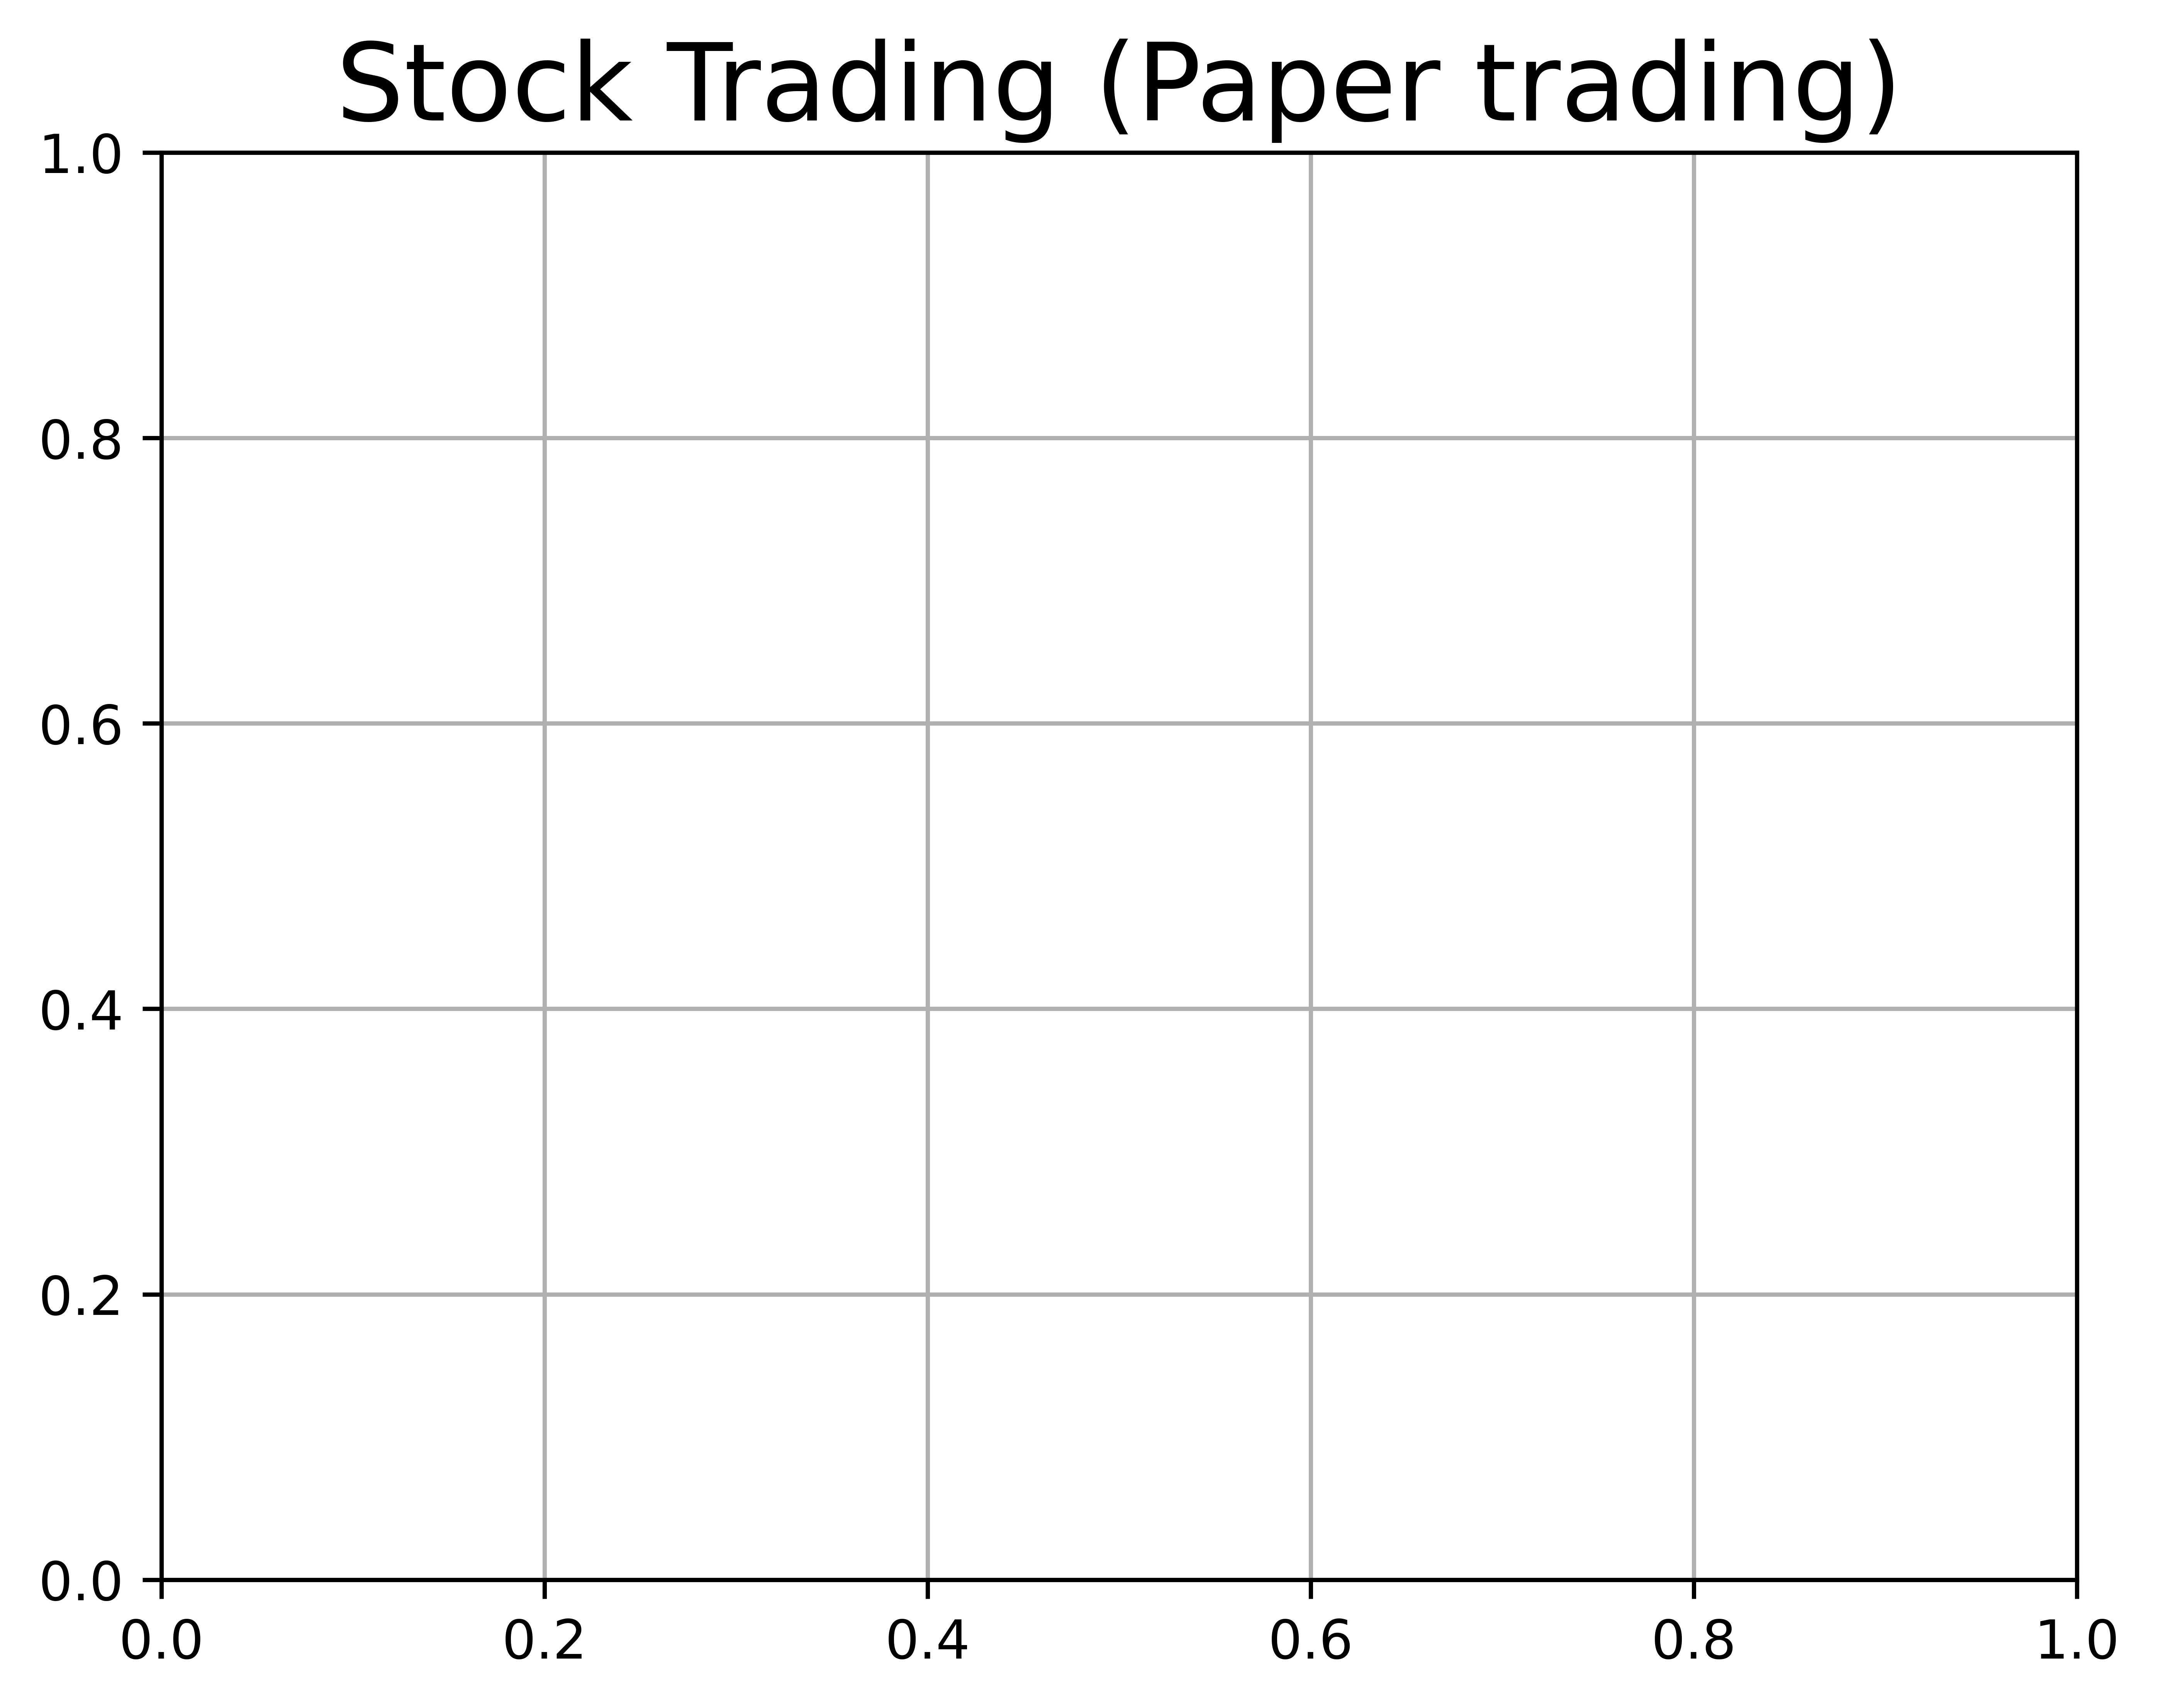

In [32]:
import matplotlib.pyplot as plt
plt.figure(dpi=1000)
plt.grid()
plt.grid(which='minor', axis='y')
plt.title('Stock Trading (Paper trading)', fontsize=20)
plt.plot(returns_erl, label = 'ElegantRL Agent', color = 'red')
#plt.plot(returns_sb3, label = 'Stable-Baselines3 Agent', color = 'blue' )
#plt.plot(returns_rllib, label = 'RLlib Agent', color = 'green')
plt.plot(returns_dia, label = 'DJIA', color = 'grey')
plt.ylabel('Return', fontsize=16)
plt.xlabel('Year 2022', fontsize=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(78))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(6))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.005))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=2))
#ax.xaxis.set_major_formatter(ticker.FixedFormatter(['','08-31','09-01','09-02','09-06','09-07','09-08','09-09','09-12']))\
ax.xaxis.set_major_formatter(ticker.FixedFormatter(['','09-06','09-07','09-08','09-09','09-12','09-13']))
plt.legend(fontsize=10.5)
plt.savefig('papertrading_stock.png')